In [33]:
# modules we'll use

import numpy as np
import pandas as pd
import gensim
import tensorflow as tf
import sys

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

#mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#sys.path.insert(0,'/content/drive/MyDrive/Praca_Inżynierska/kickstarter/code')

from preprocessing.label_binarizer import DataFrameLabelBinarizer
from preprocessing.mean_embedding_vector import MeanEmbeddingVectorizer
from plotting.loss_plotter import LossPlotter
from plotting.real_pred_plotter import RealPredPlotter

In [34]:
# read in all our data
# Google Drive's path: /content/drive/MyDrive/Praca_Inżynierska/kickstarter/data/spotify.csv
spotify_orig  = pd.read_csv("../data/spotify.csv")
# set seed for reproducibility
np.random.seed(0)

In [35]:
# look at a few rows of the Spotify dataset file
spotify_orig.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
107349,0.817,2013,0.015800,['Parmalee'],0.551,214933,0.863,0,3Bdqlr7jQLNhITAgcBGQBG,0.0000,11,0.0843,-3.506,1,Close Your Eyes,50,2013-12-10,0.0322,143.952
16271,0.548,2003,0.006610,['JAY-Z'],0.494,234627,0.887,1,7sLpSWxQazJzDVG6YGzlVs,0.0000,6,0.1030,-4.297,0,99 Problems,61,2003-11-14,0.3980,89.554
90972,0.732,2014,0.047700,['Sam Hunt'],0.590,235507,0.940,0,3BuPop8SzLG2Q88TJcFAjp,0.0000,9,0.3790,-4.124,1,Raised On It,54,2014-10-27,0.0409,94.020
84553,0.475,1981,0.000473,['Iron Maiden'],0.340,288947,0.974,0,7EvjTEzuv7TWaIaWY63sWV,0.0928,0,0.3730,-5.114,1,Drifter - 2015 Remaster,29,1981-02-02,0.1060,101.276
75895,0.550,1930,0.994000,"['Markos Vamvakaris', 'Apostolos Xatzixristos']",0.410,197653,0.169,0,38PozVGXXoeO8dTEVzy74Y,0.9010,2,0.1130,-18.862,1,Soultana maurofora,0,1930-01-01,0.0391,93.890


In [36]:
# get info about DataFrame columns
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [37]:
# convert 'key' to one-hot-encoded
lb_category = DataFrameLabelBinarizer(data_frame=spotify_orig, column_to_encode='key')
spotify_converted = lb_category.encode()

In [38]:
# convert release_date to milliseconds
spotify_converted['release_date'] = pd.to_datetime(spotify_converted['release_date'], format = "%Y-%m-%d").astype(np.int64) / 10**9

In [39]:
# drop redundant columns
spotify_reduced = spotify_converted.drop(['artists', 'name', 'year', 'id'], axis=1)

In [40]:
# get info about DataFrame columns
spotify_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   acousticness      170653 non-null  float64
 2   danceability      170653 non-null  float64
 3   duration_ms       170653 non-null  int64  
 4   energy            170653 non-null  float64
 5   explicit          170653 non-null  int64  
 6   instrumentalness  170653 non-null  float64
 7   liveness          170653 non-null  float64
 8   loudness          170653 non-null  float64
 9   mode              170653 non-null  int64  
 10  popularity        170653 non-null  int64  
 11  release_date      170653 non-null  float64
 12  speechiness       170653 non-null  float64
 13  tempo             170653 non-null  float64
 14  0                 170653 non-null  int32  
 15  1                 170653 non-null  int32  
 16  2                 17

In [41]:
# look at a few rows of the Spotify dataset
spotify_converted.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,2,3,4,5,6,7,8,9,10,11
96559,0.6250,1959,0.6820,['Martin Denny'],0.427,142400,0.4110,0,7niPihgrMNksket1T0ZbKa,0.410000,...,0,0,0,0,0,0,0,0,0,0
153920,0.5150,2012,0.0362,"['Rihanna', 'Chris Brown']",0.741,216293,0.6000,1,0qJWmTaT1qvCq0brgx8k2P,0.000000,...,0,0,0,0,0,0,0,0,0,0
77383,0.0661,1945,0.9140,"['Gustav Mahler', 'Bruno Walter', 'New York Ph...",0.261,1097547,0.2430,0,28sMV7kIkozKg1sc33Cvmf,0.917000,...,0,0,0,0,0,0,0,0,0,0
58470,0.0395,1933,0.9550,"['Johann Sebastian Bach', 'Albert Schweitzer']",0.174,202503,0.0719,0,3uHoDBPDUYKDBv5lezfCxS,0.853000,...,0,0,0,0,0,0,0,0,0,1
115209,0.8250,1971,0.1550,['Yusuf / Cat Stevens'],0.732,212667,0.6530,0,5PUP1Qicfa9rMgxAkUahIC,0.000506,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# get index of 'popularity' column
popularity_index = spotify_reduced.columns.get_loc("popularity")

In [43]:
# convert to numpy_array
spotify_numpy = spotify_reduced.to_numpy()

In [44]:
# get X and y from numpy array
X = np.delete(arr=spotify_numpy, obj=popularity_index, axis=1)
y = spotify_numpy[:, popularity_index]

In [45]:
# get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [46]:
# create model

model = keras.models.Sequential()

model.add(layers.Input(shape=(X_train.shape[1],), name='inputs'))

model.add(layers.Dense(units=30, kernel_initializer=keras.initializers.he_normal(), bias_initializer=keras.initializers.he_normal(),
                       activation=keras.activations.elu, name='hidden1'))
model.add(layers.BatchNormalization(momentum=0.99))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=15, kernel_initializer=keras.initializers.he_normal(), bias_initializer=keras.initializers.he_normal(),
                       activation=keras.activations.elu, name='hidden2'))
model.add(layers.BatchNormalization(momentum=0.99))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=1, activation=keras.activations.linear, name="outputs"))
model.add(layers.BatchNormalization(momentum=0.99))

#print model details
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 30)                780       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30)                120       
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 15)                465       
_________________________________________________________________
batch_normalization_7 (Batch (None, 15)                60        
_________________________________________________________________
dropout_5 (Dropout)          (None, 15)                0         
_________________________________________________________________
outputs (Dense)              (None, 1)                

In [47]:
# train model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss=keras.losses.mse, metrics=[keras.metrics.mse, keras.metrics.mae, keras.metrics.RootMeanSquaredError(name='rmse')])
history=model.fit(X_train, y_train, epochs=10, batch_size=170, verbose=1, validation_split=0.2)

Epoch 1/10
563/563 [==============================] - 1s 3ms/step - loss: 649.0038 - mean_squared_error: 649.0038 - mean_absolute_error: 20.3271 - rmse: 25.4756 - val_loss: 306.7963 - val_mean_squared_error: 306.7963 - val_mean_absolute_error: 13.9788 - val_rmse: 17.5156

In [48]:
# save model
model.save('models/spotify_v2_he_elu_adam_30_15')

INFO:tensorflow:Assets written to: models/spotify_v2_he_elu_adam_30_15\assets


In [49]:
# print model loss
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'rmse', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_rmse'])


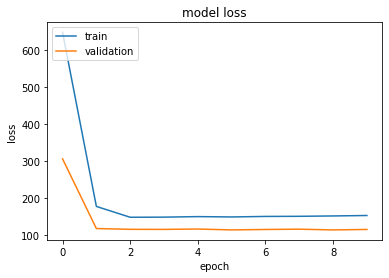

In [50]:
loss_plotter = LossPlotter(history)
loss_plotter.plot()

In [51]:
# Evaluate the model on the test data using `evaluate`
model = tf.keras.models.load_model('models/spotify_v2_he_elu_adam_30_15')
results = model.evaluate(X_test, y_test, batch_size=170)
print(results)

302/302 [==============================] - 0s 911us/step - loss: 112.2243 - mean_squared_error: 112.2243 - mean_absolute_error: 8.0297 - rmse: 10.5936

In [52]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 10 samples")
predictions = model.predict(X_test[:10])
print("predictions")
print(predictions)
real = np.reshape(y_test[:10], (-1, 1))
real_pred = np.append(real, predictions, axis=1)
print("real/predictions")
print(real_pred)

Generate predictions for 10 samples
predictions
[[34.929424]
 [34.39914 ]
 [44.44139 ]
 [17.502304]
 [ 1.685297]
 [56.655235]
 [32.24107 ]
 [ 9.517267]
 [26.567295]
 [39.534668]]
real/predictions
[[34.         34.92942429]
 [26.         34.3991394 ]
 [38.         44.44139099]
 [13.         17.50230408]
 [ 0.          1.68529701]
 [62.         56.65523529]
 [23.         32.24106979]
 [ 0.          9.51726723]
 [25.         26.56729507]
 [25.         39.53466797]]


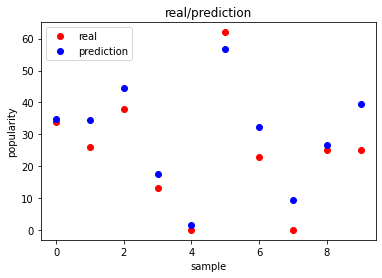

In [53]:
# plot real/pred chart
real_pred_plot = RealPredPlotter(real=real, pred=predictions)
real_pred_plot.plot()